In [1]:
from Gao_Algorithm import *
from Paisley_Algorithm import *
import matplotlib.pyplot as plt
import pandas as pd
from datafold.pcfold import PCManifold
from sklearn.model_selection import train_test_split
import GPy
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [3]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        return (x_train, y_train)

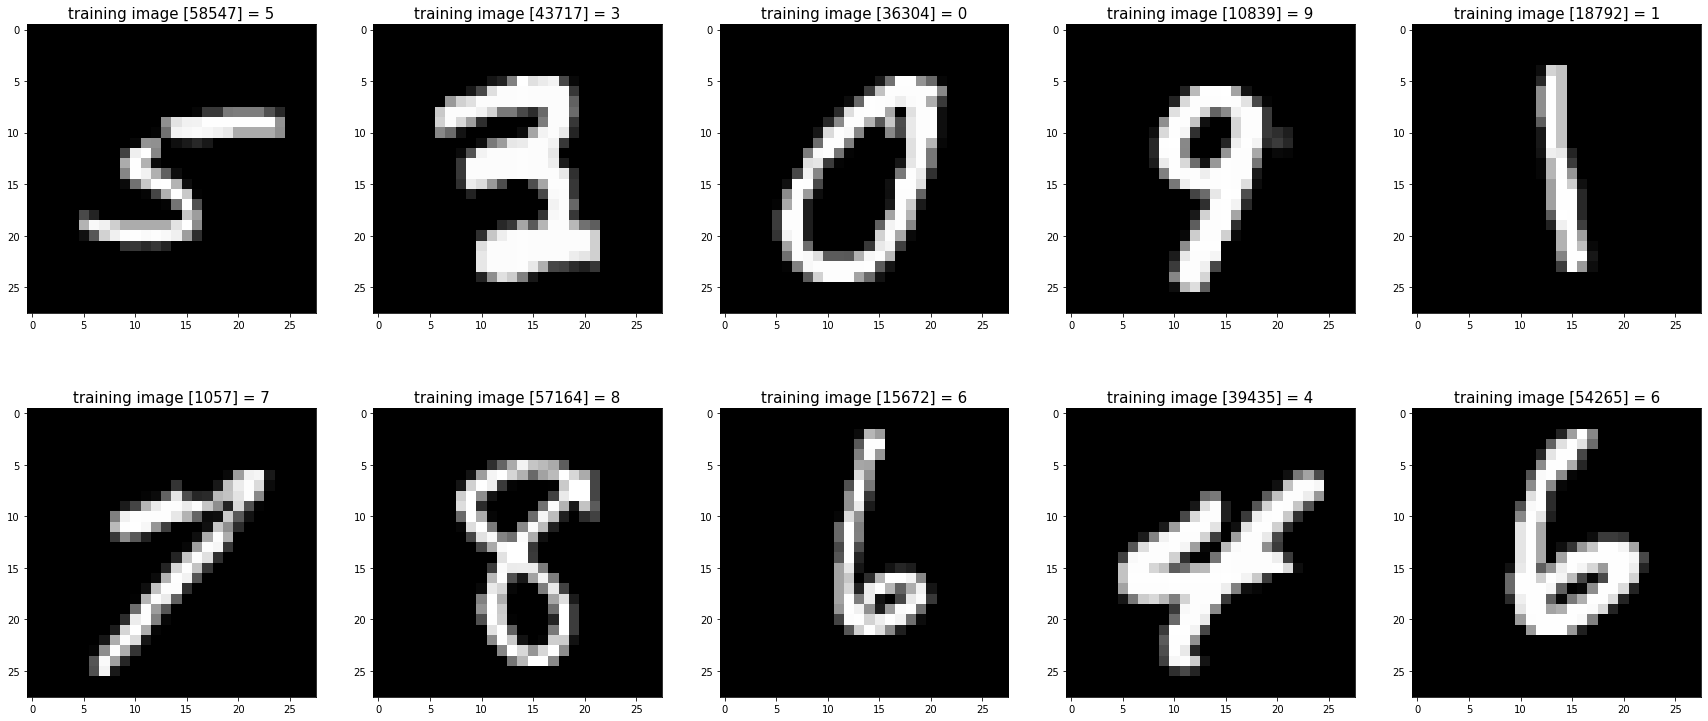

In [4]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = "C:/Users/anany/Desktop/master_thesis-master/"
#input_path = "C:/Users/Z00446CY/Desktop/master_thesis-master/"
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath)
(x_train, y_train) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

show_images(images_2_show, titles_2_show)

In [5]:
x_train = np.array(x_train) 
x_train = x_train.reshape(x_train.shape[0], -1)
x_train = x_train / 255.0

In [59]:
image = x_train
y_train = np.array(y_train)
y = y_train

In [60]:
n_classes = 10

print("Classes: ", np.unique(y))
print("Number of points per class:", [np.sum(y==k) for k in np.unique(y)])

random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(image, y, test_size=test_size, random_state=random_state)
# note that y_test and X_test is never used below.

Classes:  [0 1 2 3 4 5 6 7 8 9]
Number of points per class: [4748, 5420, 4784, 4912, 4666, 4317, 4741, 4966, 4691, 4755]


ValueError: Found input variables with inconsistent numbers of samples: [60000, 48000]

In [8]:
num_lmk_per_batch = 30 # how many landmarks to find per batch
batch_size = 100       # points per batch
n_batches = 2 # number of batches chosen per class

total_landmarks = np.array([])
idx_all = np.arange(X_train.shape[0])

# define a random number generator and use it to draw samples for batching
_rng = np.random.default_rng(random_state)
x = []
x_labels = []
for current_class in np.unique(y_train):
    
    # setup the dataset for the current class
    idx_class = (y_train == current_class)
    X_train_class = X_train[idx_class, :]
    y_train_class = y_train[idx_class]
    total_landmarks_class = np.array([])
    
    print(f"Number of points in class {current_class}: {X_train_class.shape[0]}")
    
    for _ in range(n_batches):
    
        # draw new batch at random
        batch_indices = _rng.choice(X_train_class.shape[0], size=(batch_size,))
        cat_data = X_train_class[batch_indices,:]
        x.append(cat_data)
        x_labels.append(y_train_class[batch_indices])
        # append the previous landmark data points to the array so that we can use them for the next landmarking call
        if len(total_landmarks_class) > 0:
            cat_data = np.row_stack([X_train_class[total_landmarks_class,:], cat_data])
        print(f"cat_data shape: {cat_data.shape[0]}")
        (GPLmkIdx, ptuq) = GetGPLmk_Euclidean(cat_data, num_lmk_per_batch, batch_size, BNN = 10, len(total_landmarks_class))
        # clean up the new indices by removing the ones we know
        GPLmkIdx = GPLmkIdx[len(total_landmarks_class):] - len(total_landmarks_class)
        GPLmkIdx = GPLmkIdx[GPLmkIdx >= 0]
        # add the new indices to the old ones
        unique_new_landmarks = np.unique(batch_indices[GPLmkIdx])
        total_landmarks_class = np.concatenate([total_landmarks_class, unique_new_landmarks]).astype(np.int)
    
    print(f"Found {len(total_landmarks_class)} landmarks for class {current_class}.")
    
    total_landmarks = np.concatenate([total_landmarks, idx_all[idx_class][total_landmarks_class]]).astype(np.int)
    
print(f"Total number of landmarks: {len(total_landmarks)}")
tot_landmarks = np.array(total_landmarks)
tot_landmarks = tot_landmarks.reshape(-1, )
x = np.array(x)
x = x.reshape(10 * n_batches * batch_size, -1)
x_labels = np.array(x_labels)
x_labels = x_labels.reshape(-1, )

Number of points in class 0: 4748
cat_data shape: 100
cat_data shape: 116
Found 21 landmarks for class 0.
Number of points in class 1: 5420
cat_data shape: 100
cat_data shape: 116
Found 21 landmarks for class 1.
Number of points in class 2: 4784
cat_data shape: 100
cat_data shape: 115
Found 22 landmarks for class 2.
Number of points in class 3: 4912
cat_data shape: 100
cat_data shape: 116
Found 24 landmarks for class 3.
Number of points in class 4: 4666
cat_data shape: 100
cat_data shape: 116
Found 22 landmarks for class 4.
Number of points in class 5: 4317
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 5.
Number of points in class 6: 4741
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 6.
Number of points in class 7: 4966
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 7.
Number of points in class 8: 4691
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 8.
Number of points in class 9: 4755
cat_data sha

In [9]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train[tot_landmarks, :], y_train[tot_landmarks])

In [16]:
predicted_labels = [knn.predict(X_test[i].reshape(1, -1))[0] for i in range(X_test.shape[0])]

In [28]:
x_test_prev_shape = X_test.shape[0]
x_test_and_landmarks = np.append(X_test, X_train[tot_landmarks, :], axis=0)

In [25]:
x_test_and_landmarks.shape

(12219, 784)

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(x_test_and_landmarks)

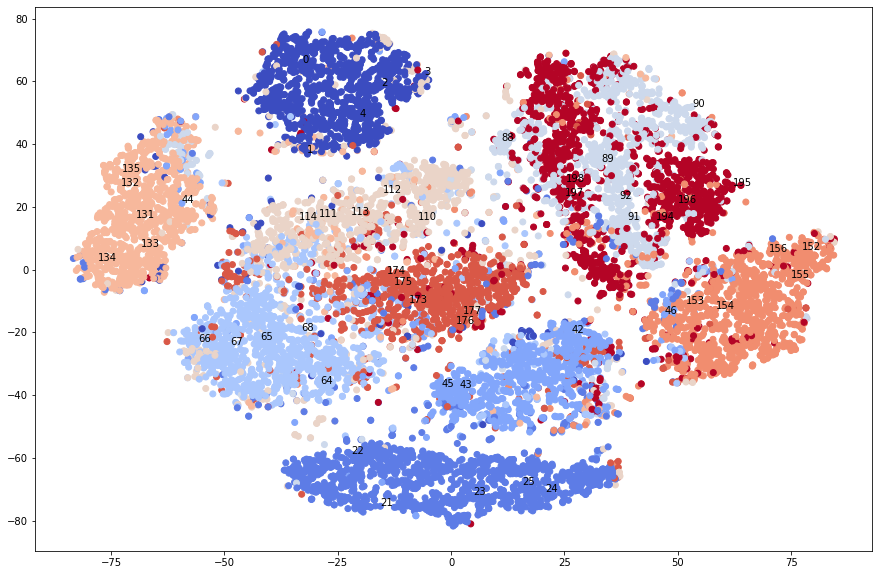

In [54]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:x_test_prev_shape, 0], tsne_results[:x_test_prev_shape, 1], c=predicted_labels, cmap = 'coolwarm' )
plt.scatter(tsne_results[x_test_prev_shape:, 0], tsne_results[x_test_prev_shape:, 1], c=y_train[tot_landmarks], cmap ='coolwarm')
n = range(219)
count = np.zeros(10)
for i, txt in enumerate(n):
    if count[y_train[tot_landmarks[i]]] < 5:
        plt.annotate(txt, (tsne_results[x_test_prev_shape + i, 0], tsne_results[x_test_prev_shape + i, 1]))
        count[y_train[tot_landmarks[i]]] += 1
plt.savefig("mnist_new_gao_tsne")

In [61]:
count = np.zeros(10)
tot_landmarks = np.array([])
labels = []
x = []
for j in range(10):
    cat_data = []
    new_labels = []
    for i in range(y_train.shape[0]):
        if (y_train[i] == j and count[y_train[i]] < 100):
            new_labels.append(y_train[i])
            cat_data.append(X_train[i])
            count[y_train[i]] += 1
    new_labels = np.array(new_labels)
    cat_data = np.array(cat_data)
    if j==0:
        mgp = ManifoldGP(n_landmarks=30, landmarks=None)
    else:
        mgp = ManifoldGP(n_landmarks=30, landmarks=tot_landmarks)
    mgp.learn_landmarks(cat_data, batch_size = 100)
    tot_landmarks = mgp.landmarks
    labels.append(new_labels)
    x.append(cat_data)
tot_landmarks = np.array(tot_landmarks)
labels = np.array(labels)
labels = labels.reshape(-1, 1)
x = np.array(x)
x.shape

bandwidth:  6.352364490397317
Learning landmark 0:
Progress: 1000/1000
Learning landmark 1:
Progress: 50/1000

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
Progress: 1000/1000
Learning landmark 25:


 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-58-29ccf5c34614>:131: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

(10, 100, 784)

In [64]:
x.shape

(10, 100, 784)

In [65]:
tot_landmarks = tot_landmarks.reshape(300,784)
x = x.reshape(1000,784)

In [70]:
knn_true = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
landmark_labels = knn_true.predict(tot_landmarks)
knn_land = KNeighborsClassifier(n_neighbors=1).fit(tot_landmarks, landmark_labels)
test_labels = knn_land.predict(X_test)

In [71]:
accuracy_score(test_labels, y_test)

0.8150833333333334

In [72]:
x_test_prev_shape = X_test.shape[0]
x_test_and_landmarks = np.append(X_test,tot_landmarks, axis=0)
x_test_and_landmarks.shape

(12300, 784)

In [73]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(x_test_and_landmarks)

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:60000, 0], tsne_results[:60000, 1], c=predicted_labels, cmap = 'coolwarm')
plt.scatter(tsne_results[60000:, 0], tsne_results[60000:, 1], c=labels ,cmap = 'coolwarm')
n = range(30)
for i, txt in enumerate(n):
    plt.annotate(txt, (tsne_results[60000 + i, 0], tsne_results[60000 + i, 1]))

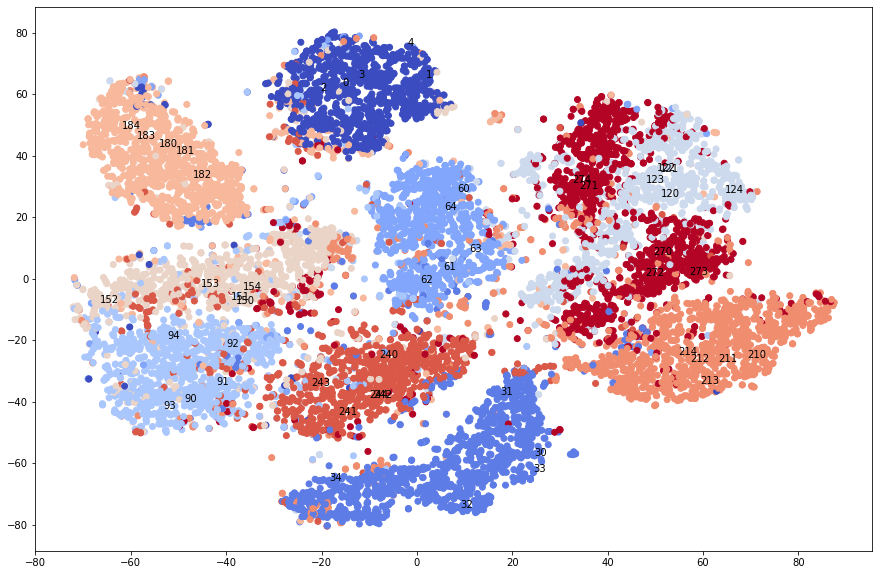

In [77]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:x_test_prev_shape, 0], tsne_results[:x_test_prev_shape, 1], c=test_labels, cmap = 'coolwarm' )
plt.scatter(tsne_results[x_test_prev_shape:, 0], tsne_results[x_test_prev_shape:, 1], c=landmark_labels, cmap ='coolwarm')
n = range(300)
count = np.zeros(10)
for i, txt in enumerate(n):
    if count[landmark_labels[i]] < 5:
        plt.annotate(txt, (tsne_results[x_test_prev_shape + i, 0], tsne_results[x_test_prev_shape + i, 1]))
        count[landmark_labels[i]] += 1
plt.savefig("mnist_new_paisley_tsne")